# CTMAP - Mouse Hypothalamic Preoptic MERFISH Dataset Analysis

This notebook executes the CTMAP (Cell Type Mapping and Alignment Protocol) analysis pipeline for predicting cell types in the mouse hypothalamic preoptic region MERFISH dataset. The workflow segments the original analysis script into modular sections for step-by-step execution while ensuring complete reproducibility of results.

The analysis includes:
- Data loading and preprocessing of scRNA-seq and MERFISH spatial transcriptomics data
- CTMAP model training for cross-modal alignment and cell type prediction
- Performance evaluation using accuracy, NMI, and ARI metrics
- Spatial distribution visualization of ground truth vs. predicted cell types
- UMAP dimensionality reduction visualization of cell type clusters

## 1. Environment Setup and Imports

In [1]:
# Set environment variables
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="Some cells have zero counts")
warnings.filterwarnings("ignore", category=FutureWarning)

# Import libraries
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score

# Set random seed
seed = 0
print(f"\n{'='*70}")
print(f"CTMAP - MERFISH | Single Run with Seed {seed}")
print(f"{'='*70}")

torch.manual_seed(seed)
np.random.seed(seed)

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


CTMAP - MERFISH | Single Run with Seed 0
Using device: cuda:0


## Part 2: Data Loading and Initial Processing

In [2]:
from CTMAP.dataprocess import cell_type_encoder, anndata_preprocess, generate_dataloaders

# Load data
print("Loading data...")
adata_r = sc.read('/opt/data/private/ywang/CTMAP-main/dataset/MERFISH/adata_rna.h5ad')
adata_s = sc.read('/opt/data/private/ywang/CTMAP-main/dataset/MERFISH/adata_merfish.h5ad')

# Extract common genes
common_genes = adata_r.var_names.intersection(adata_s.var_names)
adata_rna = adata_r[:, common_genes].copy()
adata_spa = adata_s[:, common_genes].copy()

# Add source identifiers
adata_rna.obs['source'] = 'RNA'
adata_spa.obs['source'] = 'MERFISH'
adata_rna.X = adata_rna.X.astype(np.float32)
adata_spa.X = adata_spa.X.astype(np.float32)

print(f"RNA data shape: {adata_rna.shape}")
print(f"Spatial data shape: {adata_spa.shape}")
print(f"Number of common genes: {len(common_genes)}")

Loading data...
RNA data shape: (30370, 153)
Spatial data shape: (64373, 153)
Number of common genes: 153


## Part 3: Label Encoding and Data Preprocessing

In [3]:
# Encode cell type labels
print("\nEncoding cell types...")
_, _, cell_types, label_to_name = cell_type_encoder(adata_rna, adata_spa)
print(f"Number of unique cell types: {len(cell_types)}")
print(f"Label to name mapping: {label_to_name}")

# Data preprocessing
print("\nPreprocessing data...")
adata_spa, adata_rna = anndata_preprocess(adata_spa, adata_rna)
print(f"After preprocessing - RNA shape: {adata_rna.shape}")
print(f"After preprocessing - Spatial shape: {adata_spa.shape}")


Encoding cell types...
Unique RNA Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Unique SeqFISH Labels: [ 0  1  2  3  5  7 10 11 12]
common Labels: [ 0  1  2  3  5  7 10 11]
Number of classes: 13
Number of unique cell types: 13
Label to name mapping: {0: 'Astrocyte', 1: 'Endothelial', 2: 'Ependymal', 3: 'Excitatory', 4: 'Fibroblast', 5: 'Inhibitory', 6: 'Macrophage', 7: 'Microglia', 8: 'Mural', 9: 'Newly formed OD', 10: 'OD Immature', 11: 'OD Mature', 12: 'Pericytes'}

Preprocessing data...
After preprocessing - RNA shape: (30370, 153)
After preprocessing - Spatial shape: (64373, 153)


## Part 4: Create Data Loaders

In [4]:
# Create data loaders
print("\nCreating data loaders...")
rna_train_loader, st_train_loader, rna_test_loader, st_test_loader = generate_dataloaders(adata_spa, adata_rna)

# Calculate dimensions
r_dim = len(adata_rna)
s_dim = len(adata_spa)
rna_dim = adata_rna.shape[1]
st_dim = adata_spa.shape[1]

print(f"RNA dimension: {rna_dim}")
print(f"Spatial dimension: {st_dim}")
print(f"RNA samples: {r_dim}")
print(f"Spatial samples: {s_dim}")


Creating data loaders...
RNA dimension: 153
Spatial dimension: 153
RNA samples: 30370
Spatial samples: 64373


## Part 5: Model Initialization

In [5]:
# Import model
from CTMAP.model import CTMAP

# Initialize model
print("\nInitializing CTMAP model...")
model = CTMAP(rna_dim,
              st_dim,
              latent_dim=64,
              hidden_dim=256,
              mha_heads_1=4,
              mha_dim_1=256,
              mha_dim_2=128,
              mha_heads_2=4,
              class_num=len(np.unique(adata_rna.obs['cell_type'])),
              device=device)

print(f"Model architecture:")
print(model)


Initializing CTMAP model...
Model architecture:


## Part 6: Model Training

In [6]:
# Train model
print("\nStarting model training...")
print(f"{'='*70}")

# Preserve original spatial coordinate indices
spatial_indices = np.arange(len(adata_spa))

# Train and retrieve results
truth_label, pred_label, truth_rna, rna_embeddings, st_embeddings = (
    model.train(r_dim, s_dim, rna_train_loader, st_train_loader, adata_spa.obs[["X", "Y"]],
                rna_test_loader, st_test_loader,
                lr=5e-4, maxiter=4000, miditer1=3000, log_interval=100,
                stage1_recon_weight=3.0, stage1_cls_weight=0.01,
                stage2_recon_weight=4.0, stage2_domain_weight=0.1, stage2_cls_weight=0.01)
)

print(f"\nTraining completed!")
print(f"Truth label shape: {len(truth_label)}")
print(f"Pred label shape: {len(pred_label)}")
print(f"RNA embeddings shape: {rna_embeddings.shape}")
print(f"Spatial embeddings shape: {st_embeddings.shape}")


Starting model training...
=== Starting Stage 1: Pretraining (Reconstruction + Classification) ===


Training:   3%|█▌                                                          | 106/4000 [00:02<01:03, 61.32it/s]

#Iter 100: recon_loss: 0.359234, cls loss: 2.482532, domain loss: 0.000000


Training:   5%|███▏                                                        | 215/4000 [00:04<00:47, 80.05it/s]

#Iter 200: recon_loss: 0.336991, cls loss: 2.486644, domain loss: 0.000000


Training:   8%|████▋                                                       | 313/4000 [00:05<00:57, 64.36it/s]

#Iter 300: recon_loss: 0.316649, cls loss: 2.483740, domain loss: 0.000000


Training:  10%|██████▏                                                     | 410/4000 [00:07<00:57, 62.42it/s]

#Iter 400: recon_loss: 0.301407, cls loss: 2.485245, domain loss: 0.000000


Training:  12%|███████▍                                                    | 496/4000 [00:08<00:47, 73.77it/s]

#Iter 500: recon_loss: 0.286075, cls loss: 2.484340, domain loss: 0.000000


Training:  15%|█████████▏                                                  | 609/4000 [00:10<00:48, 69.97it/s]

#Iter 600: recon_loss: 0.270919, cls loss: 2.485596, domain loss: 0.000000


Training:  18%|██████████▋                                                 | 710/4000 [00:12<00:45, 71.86it/s]

#Iter 700: recon_loss: 0.259507, cls loss: 2.484404, domain loss: 0.000000


Training:  20%|████████████▏                                               | 814/4000 [00:14<00:47, 66.53it/s]

#Iter 800: recon_loss: 0.248520, cls loss: 2.484999, domain loss: 0.000000


Training:  23%|█████████████▋                                              | 914/4000 [00:15<00:38, 80.78it/s]

#Iter 900: recon_loss: 0.231599, cls loss: 2.484593, domain loss: 0.000000


Training:  25%|██████████████▉                                             | 999/4000 [00:16<00:42, 71.15it/s]

#Iter 1000: recon_loss: 0.218735, cls loss: 2.484868, domain loss: 0.000000


Training:  28%|████████████████▍                                          | 1114/4000 [00:19<00:45, 63.89it/s]

#Iter 1100: recon_loss: 0.208533, cls loss: 2.484675, domain loss: 0.000000


Training:  30%|█████████████████▊                                         | 1211/4000 [00:20<00:35, 77.60it/s]

#Iter 1200: recon_loss: 0.196570, cls loss: 2.484322, domain loss: 0.000000


Training:  33%|███████████████████▎                                       | 1310/4000 [00:22<00:54, 49.40it/s]

#Iter 1300: recon_loss: 0.189481, cls loss: 2.484109, domain loss: 0.000000


Training:  35%|████████████████████▊                                      | 1409/4000 [00:24<00:41, 62.84it/s]

#Iter 1400: recon_loss: 0.178702, cls loss: 2.485225, domain loss: 0.000000


Training:  37%|██████████████████████                                     | 1499/4000 [00:25<00:32, 77.70it/s]

#Iter 1500: recon_loss: 0.171051, cls loss: 2.485186, domain loss: 0.000000


Training:  40%|███████████████████████▊                                   | 1613/4000 [00:27<00:34, 69.51it/s]

#Iter 1600: recon_loss: 0.161323, cls loss: 2.484956, domain loss: 0.000000


Training:  43%|█████████████████████████▎                                 | 1715/4000 [00:29<00:27, 82.32it/s]

#Iter 1700: recon_loss: 0.153176, cls loss: 2.484468, domain loss: 0.000000


Training:  45%|██████████████████████████▋                                | 1811/4000 [00:31<00:34, 62.94it/s]

#Iter 1800: recon_loss: 0.145135, cls loss: 2.484408, domain loss: 0.000000


Training:  48%|████████████████████████████▏                              | 1915/4000 [00:32<00:26, 79.59it/s]

#Iter 1900: recon_loss: 0.138371, cls loss: 2.485741, domain loss: 0.000000


Training:  50%|█████████████████████████████▌                             | 2006/4000 [00:33<00:29, 66.79it/s]

#Iter 2000: recon_loss: 0.132464, cls loss: 2.484193, domain loss: 0.000000


Training:  53%|███████████████████████████████▏                           | 2112/4000 [00:35<00:29, 63.53it/s]

#Iter 2100: recon_loss: 0.125699, cls loss: 2.485362, domain loss: 0.000000


Training:  55%|████████████████████████████████▌                          | 2208/4000 [00:37<00:21, 85.06it/s]

#Iter 2200: recon_loss: 0.120433, cls loss: 2.485276, domain loss: 0.000000


Training:  58%|██████████████████████████████████                         | 2311/4000 [00:39<00:26, 63.84it/s]

#Iter 2300: recon_loss: 0.113747, cls loss: 2.484219, domain loss: 0.000000


Training:  60%|███████████████████████████████████▌                       | 2410/4000 [00:40<00:19, 80.82it/s]

#Iter 2400: recon_loss: 0.109736, cls loss: 2.485038, domain loss: 0.000000


Training:  63%|████████████████████████████████████▉                      | 2505/4000 [00:41<00:20, 71.42it/s]

#Iter 2500: recon_loss: 0.106162, cls loss: 2.484561, domain loss: 0.000000


Training:  65%|██████████████████████████████████████▍                    | 2610/4000 [00:43<00:20, 66.20it/s]

#Iter 2600: recon_loss: 0.101090, cls loss: 2.484394, domain loss: 0.000000


Training:  68%|████████████████████████████████████████                   | 2713/4000 [00:44<00:15, 82.46it/s]

#Iter 2700: recon_loss: 0.096467, cls loss: 2.485038, domain loss: 0.000000


Training:  70%|█████████████████████████████████████████▌                 | 2814/4000 [00:46<00:18, 63.91it/s]

#Iter 2800: recon_loss: 0.094118, cls loss: 2.484840, domain loss: 0.000000


Training:  73%|██████████████████████████████████████████▉                | 2910/4000 [00:48<00:14, 74.68it/s]

#Iter 2900: recon_loss: 0.089586, cls loss: 2.484987, domain loss: 0.000000


Training:  75%|████████████████████████████████████████████▎              | 3005/4000 [00:49<00:13, 75.39it/s]

#Iter 3000: recon_loss: 0.086352, cls loss: 2.484656, domain loss: 0.000000

=== Stage 1 Completed ===
=== Starting Stage 2: Domain Adversarial Training ===



Training:  78%|█████████████████████████████████████████████▉             | 3111/4000 [00:51<00:14, 61.09it/s]

#Iter 3100: recon_loss: 0.081760, cls loss: 2.485259, domain loss: 1.383129


Training:  80%|███████████████████████████████████████████████▍           | 3212/4000 [00:53<00:11, 66.02it/s]

#Iter 3200: recon_loss: 0.077953, cls loss: 2.484393, domain loss: 1.385284


Training:  83%|████████████████████████████████████████████████▊          | 3306/4000 [00:55<00:13, 52.10it/s]

#Iter 3300: recon_loss: 0.073374, cls loss: 2.484798, domain loss: 1.385005


Training:  85%|██████████████████████████████████████████████████▎        | 3411/4000 [00:56<00:09, 62.78it/s]

#Iter 3400: recon_loss: 0.070070, cls loss: 2.485437, domain loss: 1.385204


Training:  88%|███████████████████████████████████████████████████▊       | 3511/4000 [00:58<00:06, 70.50it/s]

#Iter 3500: recon_loss: 0.068012, cls loss: 2.484529, domain loss: 1.385411


Training:  90%|█████████████████████████████████████████████████████▏     | 3608/4000 [01:00<00:06, 60.14it/s]

#Iter 3600: recon_loss: 0.065351, cls loss: 2.484610, domain loss: 1.385383


Training:  93%|██████████████████████████████████████████████████████▊    | 3712/4000 [01:02<00:05, 55.63it/s]

#Iter 3700: recon_loss: 0.061653, cls loss: 2.485136, domain loss: 1.385414


Training:  95%|████████████████████████████████████████████████████████▏  | 3811/4000 [01:04<00:03, 52.59it/s]

#Iter 3800: recon_loss: 0.060417, cls loss: 2.484929, domain loss: 1.385444


Training:  98%|█████████████████████████████████████████████████████████▋ | 3908/4000 [01:06<00:01, 57.32it/s]

#Iter 3900: recon_loss: 0.057458, cls loss: 2.485142, domain loss: 1.385459


Training: 100%|███████████████████████████████████████████████████████████| 4000/4000 [01:07<00:00, 62.07it/s]

#Iter 4000: recon_loss: 0.055800, cls loss: 2.484606, domain loss: 1.385740


Training: 100%|███████████████████████████████████████████████████████████| 4000/4000 [01:14<00:00, 53.74it/s]


Training completed!
Truth label shape: 64373
Pred label shape: 64373
RNA embeddings shape: (30370, 64)
Spatial embeddings shape: (64373, 64)


## Part 7: Results Evaluation

In [7]:
# Map indices to cell type names
print("\nEvaluating results...")
truth_ct = [label_to_name[i] for i in truth_label]
pred_ct = [label_to_name[i] for i in pred_label]

# Calculate evaluation metrics
accuracy = accuracy_score(truth_ct, pred_ct)
nmi = normalized_mutual_info_score(truth_ct, pred_ct)
ari = adjusted_rand_score(truth_ct, pred_ct)

print(f"\n{'='*70}")
print("FINAL RESULTS")
print(f"Accuracy: {accuracy:.4f}")
print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"{'='*70}")


Evaluating results...

FINAL RESULTS
Accuracy: 0.8907
NMI: 0.7833
ARI: 0.7888


## Part 8: Spatial Distribution Visualization


Visualizing spatial distribution...
Total spots: 64373
Spots with 8 major cell types: 62591


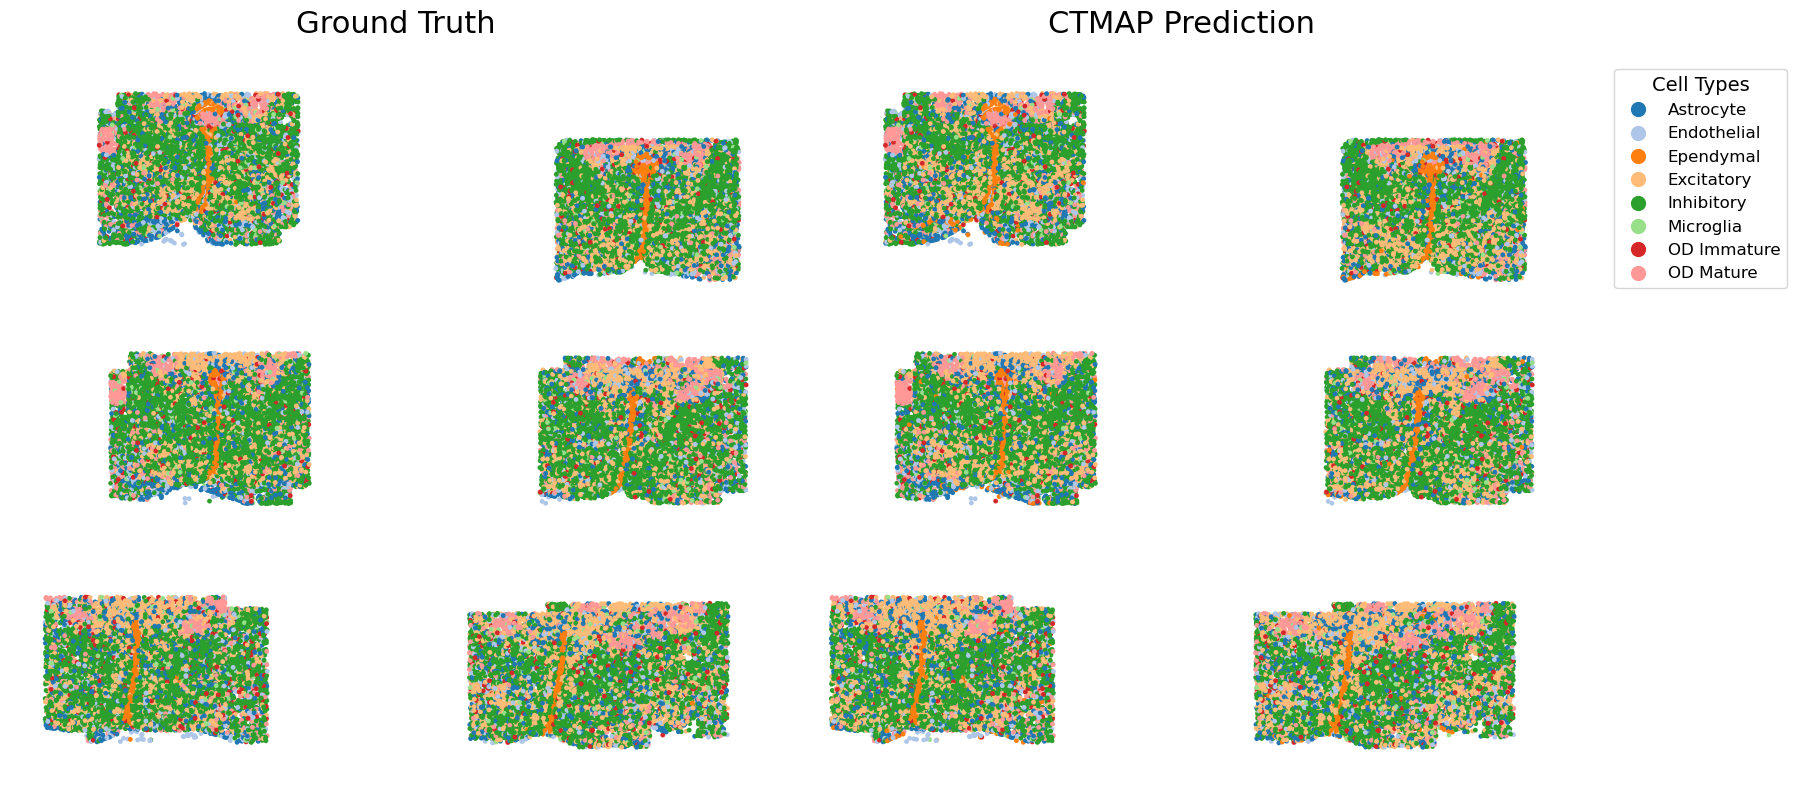


Spatial visualization saved to results/merfish_spatial_8major_runpy.png


In [8]:
# Create results directory
os.makedirs("results", exist_ok=True)

# Define major cell types and color mapping (ensure exact match with dataset names)
major_celltypes = [
    "Astrocyte", "Endothelial", "Ependymal", "Excitatory",
    "Inhibitory", "Microglia", "OD Immature", "OD Mature"
]
color_map = [
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78",
    "#2ca02c", "#98df8a", "#d62728", "#ff9896"
]
color_dict = dict(zip(major_celltypes, color_map))

# Convert to numpy arrays for indexing
truth_ct_names = np.array(truth_ct)
pred_ct_names = np.array(pred_ct)

# Critical fix: Create consistent filtering mask to ensure ground truth and predictions correspond to the same samples
common_mask = np.isin(truth_ct_names, major_celltypes) & np.isin(pred_ct_names, major_celltypes)

# Extract filtered coordinates (maintaining one-to-one correspondence with labels)
X = adata_spa.obs['X'].values[common_mask]
Y = adata_spa.obs['Y'].values[common_mask]
truth_colors = [color_dict[ct] for ct in truth_ct_names[common_mask]]
pred_colors = [color_dict[ct] for ct in pred_ct_names[common_mask]]

print(f"\nVisualizing spatial distribution...")
print(f"Total spots: {len(adata_spa)}")
print(f"Spots with 8 major cell types: {common_mask.sum()}")

# Plot spatial distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].scatter(X, Y, c=truth_colors, s=12, linewidth=0)
axes[0].set_title("Ground Truth", fontsize=22, pad=20)
axes[0].axis("off")

axes[1].scatter(X, Y, c=pred_colors, s=12, linewidth=0)
axes[1].set_title("CTMAP Prediction", fontsize=22, pad=20)
axes[1].axis("off")

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=ct,
                      markerfacecolor=color_dict[ct], markersize=12)
           for ct in major_celltypes]
axes[1].legend(handles=handles, title="Cell Types",
               loc="upper left", bbox_to_anchor=(1.05, 1),
               fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.savefig("results/merfish_spatial_8major_runpy.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\nSpatial visualization saved to results/merfish_spatial_8major_runpy.png")

## Part 9: UMAP Visualization


Creating UMAP visualizations...
Computing UMAP on 62591 spots with 8 major cell types...


/opt/data/private/ywang/anaconda3/envs/pytorch/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 64 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


Creating UMAP for ground truth...


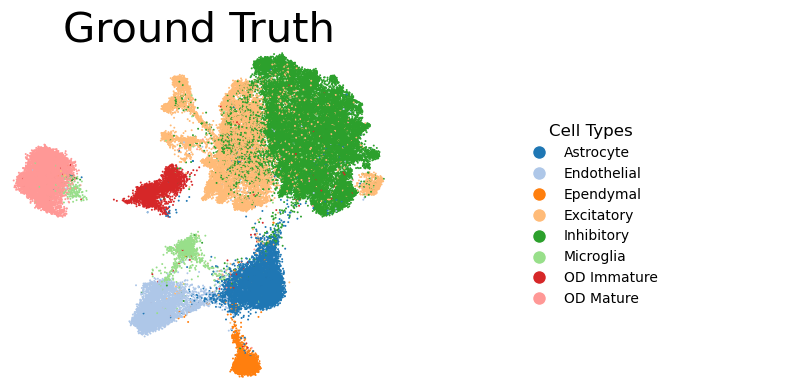

Creating UMAP for CTMAP predictions...


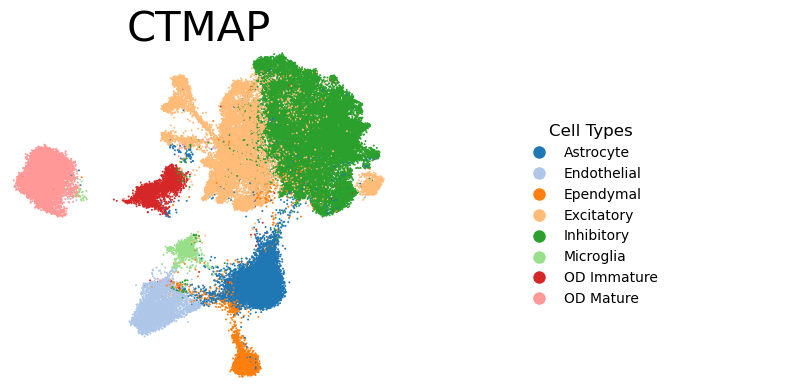


UMAP visualization completed!
Images saved to results/umap_ground_truth.png and results/umap_ctmap.png


In [11]:
print("\nCreating UMAP visualizations...")

# Create AnnData object for visualization
adata_vis = sc.AnnData(st_embeddings)
adata_vis.obs['truth_ct'] = truth_ct_names
adata_vis.obs['pred_ct_ctmap'] = pred_ct_names

# Maintain filtering consistency for UMAP visualization
major_mask = adata_vis.obs['truth_ct'].isin(major_celltypes) & adata_vis.obs['pred_ct_ctmap'].isin(major_celltypes)
adata_vis_filtered = adata_vis[major_mask].copy()

print(f"Computing UMAP on {adata_vis_filtered.n_obs} spots with 8 major cell types...")

# Compute neighbors and UMAP
sc.pp.neighbors(adata_vis_filtered, n_neighbors=15, method='umap')
sc.tl.umap(adata_vis_filtered)

# Plot UMAP - Ground Truth
print("Creating UMAP for ground truth...")
fig = plt.figure(figsize=(8, 4))  # 增加宽度以容纳图例

# 创建两个子图，左侧是UMAP，右侧是图例
ax1 = plt.subplot(1, 2, 1)
sc.pl.umap(
    adata_vis_filtered,
    color='truth_ct',
    palette=color_map,
    legend_loc=None,
    frameon=False,
    title='',
    size=8,
    show=False,
    ax=ax1
)
ax1.set_title('Ground Truth', fontsize=30, pad=5)
ax1.margins(x=0.01, y=0.01)

# 右侧子图用于图例
ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')  # 隐藏坐标轴

# 创建图例项
handles = []
for i, cell_type in enumerate(major_celltypes):
    if cell_type in adata_vis_filtered.obs['truth_ct'].unique():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color_map[i], 
                                 markersize=10, label=cell_type))

# 在图例子图中添加图例
ax2.legend(handles=handles, loc='center', fontsize=10, 
           title='Cell Types', title_fontsize=12,
           frameon=False)

plt.tight_layout()
save_path = "results/umap_ground_truth.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

# Plot UMAP - CTMAP predictions
print("Creating UMAP for CTMAP predictions...")
fig = plt.figure(figsize=(8, 4))  # 增加宽度以容纳图例

# 创建两个子图，左侧是UMAP，右侧是图例
ax1 = plt.subplot(1, 2, 1)
sc.pl.umap(
    adata_vis_filtered,
    color='pred_ct_ctmap',
    palette=color_map,
    legend_loc=None,
    frameon=False,
    title='',
    size=8,
    show=False,
    ax=ax1
)
ax1.set_title('CTMAP', fontsize=30, pad=5)
ax1.margins(x=0.01, y=0.01)

# 右侧子图用于图例
ax2 = plt.subplot(1, 2, 2)
ax2.axis('off')  # 隐藏坐标轴

# 创建图例项
handles = []
for i, cell_type in enumerate(major_celltypes):
    if cell_type in adata_vis_filtered.obs['pred_ct_ctmap'].unique():
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=color_map[i], 
                                 markersize=10, label=cell_type))

# 在图例子图中添加图例
ax2.legend(handles=handles, loc='center', fontsize=10, 
           title='Cell Types', title_fontsize=12,
           frameon=False)

plt.tight_layout()
save_path = "results/umap_ctmap.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

print("\nUMAP visualization completed!")
print("Images saved to results/umap_ground_truth.png and results/umap_ctmap.png")